# Simple Neural Network
Follow the example in [You Don't Know JAX](https://colinraffel.com/blog/you-don-t-know-jax.html) to see whether JAX-Metal is working ok.  Also try to do the derivation in sympy at the same time.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as np
import numpy as onp  # 'Original' numpy
import sympy as sp

In [3]:
sp.init_printing(use_latex=True)

In [4]:
jax.devices()

Metal device set to: Apple M2


2023-10-08 10:29:10.254709: W pjrt_plugin/src/mps_client.cc:534] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
2023-10-08 10:29:10.267 Python[1225:11883] apply_selection_policy_once: avoid use of removable GPUs (via org.python.python:GPUSelectionPolicy->avoidRemovable)


[MetalDevice(id=0, process_index=0)]

# Symbol and Equation Definition
Write factory functions for the sigmoid, neural network with single hidden layer, cross-entropy, and loss functions.  These factory functions allow us to feed in different versions of e.g. `exp` depending on whether we are constructing a SymPy model or JAX model.

In [5]:
def create_sigmoid(exp):
    def inner(x):
        return 1/(1 + exp(-x))  # TODO: 2023-10-07 I think this needs to be a matrix expression for the non-explicit MatrixSymbol to work, as for cross-entropy
    return inner

In [78]:
# tanh form of sigmoid function for SymPy version - avoids strange problem with MatExpr being added to Scalar 
def create_sigmoid_tanh():
    def inner(x):
        return (sp.tanh(x/2) + 1)/2
    return inner

In [6]:
def create_net(sig, tanh):
    def inner(params, x):
        w1, b1, w2, b2 = params
        hidden = tanh(w1 @ x + b1)
        return sig(w2 @ hidden + b2) 
    return inner

In [7]:
def create_cross_entropy(log, min_1):
    def inner(y, y_pred):
        return -y*log(y_pred) - min_1(y)*log(min_1(y_pred))
    return inner

In [8]:
def create_loss(cross_entropy, net):
    def inner(params, x, y):
        out = net(params, x)
        return cross_entropy(y, out)
    return inner

In [79]:
# net_sp = create_net(lambda x: x.applyfunc(create_sigmoid(sp.exp)), lambda x: x.applyfunc(sp.tanh))
net_sp = create_net(lambda x: x.applyfunc(create_sigmoid_tanh()), lambda x: x.applyfunc(sp.tanh))

In [80]:
cross_entropy_sp = create_cross_entropy(lambda x: x.applyfunc(sp.log), lambda x: sp.Matrix([1]) - x)

In [81]:
loss_sp = create_loss(
    cross_entropy_sp, 
    net_sp
)

In [82]:
param_desc = [('w__1', 3, 2), ('b__1', 3, 1), ('w__2', 1, 3), ('b__2', 1, 1)]

In [83]:
def create_sympy_vars(param_desc):
    x = sp.MatrixSymbol('x', param_desc[0][-1], 1)
    y = sp.MatrixSymbol('y', 1, param_desc[-1][1])
    w1, b1, w2, b2 = [sp.MatrixSymbol(p, n, m) for p, n, m in param_desc]
    return x, y, w1, b1, w2, b2

In [84]:
# x_sp, y_sp, w1, b1, w2, b2 = [e.as_explicit() for e in create_sympy_vars(param_desc)]
x_sp, y_sp, w1, b1, w2, b2 = create_sympy_vars(param_desc)
params_sp = [w1, b1, w2, b2]

In [85]:
h_sp = sp.MatrixSymbol('h', 3, 1)
z_sp = sp.MatrixSymbol('z', 1, 1)

In [86]:
def explicit_eqn(expr):
    """Helper function to show matrix symbols in implict and explicit forms"""
    return sp.Eq(sp.UnevaluatedExpr(expr), sp.UnevaluatedExpr(expr.as_explicit()))

# Neural Network Function

In [87]:
explicit_eqn(net_sp(params_sp, x_sp))

⎛        ⎛d⎞    ⎞                                                                                                                                                          
⎜    tanh⎜─⎟    ⎟                                       ⎡    ⎛tanh(b¹₀₀ + w¹₀₀⋅x₀₀ + w¹₀₁⋅x₁₀)⋅w²₀₀   tanh(b¹₁₀ + w¹₁₀⋅x₀₀ + w¹₁₁⋅x₁₀)⋅w²₀₁   tanh(b¹₂₀ + w¹₂₀⋅x₀₀ + w¹₂₁⋅x
⎜        ⎝2⎠   1⎟                                       ⎢tanh⎜───────────────────────────────────── + ───────────────────────────────────── + ─────────────────────────────
⎜d ↦ ─────── + ─⎟˳(w²⋅(d ↦ tanh(d))˳(w¹⋅x + b¹) + b²) = ⎢    ⎝                  2                                       2                                       2          
⎝       2      2⎠                                       ⎢──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                        ⎣                                                                2                  

# Hidden layer in terms of inputs

In [88]:
h = (w1 @ x_sp + b1).applyfunc(sp.tanh)
sp.Eq(sp.UnevaluatedExpr(h_sp), sp.UnevaluatedExpr(explicit_eqn(h)))

                                ⎡tanh(b¹₀₀ + w¹₀₀⋅x₀₀ + w¹₀₁⋅x₁₀)⎤
                                ⎢                                ⎥
h = (d ↦ tanh(d))˳(w¹⋅x + b¹) = ⎢tanh(b¹₁₀ + w¹₁₀⋅x₀₀ + w¹₁₁⋅x₁₀)⎥
                                ⎢                                ⎥
                                ⎣tanh(b¹₂₀ + w¹₂₀⋅x₀₀ + w¹₂₁⋅x₁₀)⎦

In [92]:
# explicit_eqn((w2 @ h + b2).applyfunc(create_sigmoid(sp.exp)))
explicit_eqn((w2 @ h + b2).applyfunc(create_sigmoid_tanh()))

⎛        ⎛d⎞    ⎞                                                                                                                                                          
⎜    tanh⎜─⎟    ⎟                                       ⎡    ⎛tanh(b¹₀₀ + w¹₀₀⋅x₀₀ + w¹₀₁⋅x₁₀)⋅w²₀₀   tanh(b¹₁₀ + w¹₁₀⋅x₀₀ + w¹₁₁⋅x₁₀)⋅w²₀₁   tanh(b¹₂₀ + w¹₂₀⋅x₀₀ + w¹₂₁⋅x
⎜        ⎝2⎠   1⎟                                       ⎢tanh⎜───────────────────────────────────── + ───────────────────────────────────── + ─────────────────────────────
⎜d ↦ ─────── + ─⎟˳(w²⋅(d ↦ tanh(d))˳(w¹⋅x + b¹) + b²) = ⎢    ⎝                  2                                       2                                       2          
⎝       2      2⎠                                       ⎢──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                        ⎣                                                                2                  

In [93]:
# (w2 @ h_sp + b2).applyfunc(create_sigmoid(sp.exp))
(w2 @ h_sp + b2).applyfunc(create_sigmoid_tanh())

In [94]:
h.diff(x_sp).as_explicit()

⎡⎛        2                            ⎞       ⎛        2                            ⎞       ⎛        2                            ⎞     ⎤
⎢⎝1 - tanh (b¹₀₀ + w¹₀₀⋅x₀₀ + w¹₀₁⋅x₁₀)⎠⋅w¹₀₀  ⎝1 - tanh (b¹₁₀ + w¹₁₀⋅x₀₀ + w¹₁₁⋅x₁₀)⎠⋅w¹₁₀  ⎝1 - tanh (b¹₂₀ + w¹₂₀⋅x₀₀ + w¹₂₁⋅x₁₀)⎠⋅w¹₂₀⎥
⎢                                                                                                                                        ⎥
⎢⎛        2                            ⎞       ⎛        2                            ⎞       ⎛        2                            ⎞     ⎥
⎣⎝1 - tanh (b¹₀₀ + w¹₀₀⋅x₀₀ + w¹₀₁⋅x₁₀)⎠⋅w¹₀₁  ⎝1 - tanh (b¹₁₀ + w¹₁₀⋅x₀₀ + w¹₁₁⋅x₁₀)⎠⋅w¹₁₁  ⎝1 - tanh (b¹₂₀ + w¹₂₀⋅x₀₀ + w¹₂₁⋅x₁₀)⎠⋅w¹₂₁⎦

In [95]:
h.diff(w1)#.as_explicit()

In [96]:
dh = h.as_explicit().jacobian(x_sp)
dh

⎡⎛        2                            ⎞       ⎛        2                            ⎞     ⎤
⎢⎝1 - tanh (b¹₀₀ + w¹₀₀⋅x₀₀ + w¹₀₁⋅x₁₀)⎠⋅w¹₀₀  ⎝1 - tanh (b¹₀₀ + w¹₀₀⋅x₀₀ + w¹₀₁⋅x₁₀)⎠⋅w¹₀₁⎥
⎢                                                                                          ⎥
⎢⎛        2                            ⎞       ⎛        2                            ⎞     ⎥
⎢⎝1 - tanh (b¹₁₀ + w¹₁₀⋅x₀₀ + w¹₁₁⋅x₁₀)⎠⋅w¹₁₀  ⎝1 - tanh (b¹₁₀ + w¹₁₀⋅x₀₀ + w¹₁₁⋅x₁₀)⎠⋅w¹₁₁⎥
⎢                                                                                          ⎥
⎢⎛        2                            ⎞       ⎛        2                            ⎞     ⎥
⎣⎝1 - tanh (b¹₂₀ + w¹₂₀⋅x₀₀ + w¹₂₁⋅x₁₀)⎠⋅w¹₂₀  ⎝1 - tanh (b¹₂₀ + w¹₂₀⋅x₀₀ + w¹₂₁⋅x₁₀)⎠⋅w¹₂₁⎦

In [97]:
(w2 @ h_sp + b2).as_explicit().applyfunc(lambda x: 1/(1-sp.exp(x)))#.diff(w2.as_explicit())

⎡                    1                     ⎤
⎢──────────────────────────────────────────⎥
⎢     b²₀₀ + h₀₀⋅w²₀₀ + h₁₀⋅w²₀₁ + h₂₀⋅w²₀₂⎥
⎣1 - ℯ                                     ⎦

In [98]:
# z = (w2 @ h_sp + b2).applyfunc(lambda x: 1/(1-sp.exp(x)))
z = (w2 @ h_sp + b2).applyfunc(lambda x: (1 + sp.tanh(x/2))/2)

dz = z.as_explicit().jacobian(h_sp[:])

In [102]:
z.diff(h_sp)

In [100]:
z.as_explicit().diff(b2.as_explicit())

⎡⎡⎡⎡        2⎛b²₀₀   h₀₀⋅w²₀₀   h₁₀⋅w²₀₁   h₂₀⋅w²₀₂⎞⎤⎤⎤⎤
⎢⎢⎢⎢    tanh ⎜──── + ──────── + ──────── + ────────⎟⎥⎥⎥⎥
⎢⎢⎢⎢1        ⎝ 2        2          2          2    ⎠⎥⎥⎥⎥
⎢⎢⎢⎢─ - ────────────────────────────────────────────⎥⎥⎥⎥
⎣⎣⎣⎣4                        4                      ⎦⎦⎦⎦

In [103]:
l = cross_entropy_sp(z, z_sp)
dl = l.as_explicit().jacobian(z_sp)
dl

⎡      ⎛b²₀₀   h₀₀⋅w²₀₀   h₁₀⋅w²₀₁   h₂₀⋅w²₀₂⎞           ⎛b²₀₀   h₀₀⋅w²₀₀   h₁₀⋅w²₀₁   h₂₀⋅w²₀₂⎞    ⎤
⎢  tanh⎜──── + ──────── + ──────── + ────────⎟       tanh⎜──── + ──────── + ──────── + ────────⎟    ⎥
⎢      ⎝ 2        2          2          2    ⎠   1       ⎝ 2        2          2          2    ⎠   1⎥
⎢- ─────────────────────────────────────────── - ─   ─────────────────────────────────────────── - ─⎥
⎢                       2                        2                        2                        2⎥
⎢───────────────────────────────────────────────── - ───────────────────────────────────────────────⎥
⎣                       z₀₀                                              1 - z₀₀                    ⎦

In [104]:
(dl @ dz @ dh).simplify()

⎡ ⎛⎛    ⎛b²₀₀   h₀₀⋅w²₀₀   h₁₀⋅w²₀₁   h₂₀⋅w²₀₂⎞    ⎞       ⎛    ⎛b²₀₀   h₀₀⋅w²₀₀   h₁₀⋅w²₀₁   h₂₀⋅w²₀₂⎞    ⎞          ⎞ ⎛⎛    2                                ⎞           
⎢-⎜⎜tanh⎜──── + ──────── + ──────── + ────────⎟ - 1⎟⋅z₀₀ - ⎜tanh⎜──── + ──────── + ──────── + ────────⎟ + 1⎟⋅(z₀₀ - 1)⎟⋅⎝⎝tanh (b¹₀₀ + w¹₀₀⋅x₀₀ + w¹₀₁⋅x₁₀) - 1⎠⋅w¹₀₀⋅w²₀₀ 
⎢ ⎝⎝    ⎝ 2        2          2          2    ⎠    ⎠       ⎝    ⎝ 2        2          2          2    ⎠    ⎠          ⎠                                                    
⎢──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
⎢                                                                                                                            2⎛b²₀₀   h₀₀⋅w²₀₀   h₁₀⋅w²₀₁   h₂₀⋅w²₀₂⎞      
⎢                                                                                                            8⋅(z₀₀ - 1)⋅cosh ⎜──── + ──────

In [108]:
l

 ⎛ ⎛        ⎛d⎞    ⎞                  ⎞                          ⎛        ⎛d⎞    ⎞                             
 ⎜ ⎜    tanh⎜─⎟    ⎟                  ⎟                          ⎜    tanh⎜─⎟    ⎟                             
 ⎜ ⎜        ⎝2⎠   1⎟                  ⎟                          ⎜        ⎝2⎠   1⎟                             
-⎜-⎜d ↦ ─────── + ─⎟˳(w²⋅h + b²) + [1]⎟⋅(d ↦ log(d))˳(-z + [1]) -⎜d ↦ ─────── + ─⎟˳(w²⋅h + b²)⋅(d ↦ log(d))˳(z)
 ⎝ ⎝       2      2⎠                  ⎠                          ⎝       2      2⎠                             

In [29]:
loss_sp(params_sp, x_sp, y_sp)

                         ⎛ ⎛       1   ⎞                                          ⎞    ⎛       ⎛   1   ⎞⎞                                    
-(-y + [1])⋅(d ↦ log(d))˳⎜-⎜d ↦ ───────⎟˳(w²⋅(d ↦ tanh(d))˳(w¹⋅x + b¹) + b²) + [1]⎟ -y⋅⎜d ↦ log⎜───────⎟⎟˳(w²⋅(d ↦ tanh(d))˳(w¹⋅x + b¹) + b²)
                         ⎜ ⎜         -d⎟                                          ⎟    ⎜       ⎜     -d⎟⎟                                    
                         ⎝ ⎝    1 + ℯ  ⎠                                          ⎠    ⎝       ⎝1 + ℯ  ⎠⎠                                    

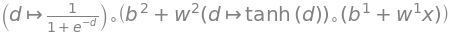

In [30]:
net_sp(params_sp, x_sp)

In [31]:
# Flatten all parameters into a vector - may not be needed 
all_params = sum([p.as_explicit().flat() for p in params_sp], [])

In [32]:
loss_grad_sp = loss_sp(params_sp, x_sp, y_sp).as_explicit().jacobian(all_params)

In [33]:
loss_grad_sp

⎡  ⎛        2                            ⎞  -tanh(b¹₀₀ + w¹₀₀⋅x₀₀ + w¹₀₁⋅x₁₀)⋅w²₀₀ - tanh(b¹₁₀ + w¹₁₀⋅x₀₀ + w¹₁₁⋅x₁₀)⋅w²₀₁ - tanh(b¹₂₀ + w¹₂₀⋅x₀₀ + w¹₂₁⋅x₁₀)⋅w²₀₂ - b²₀₀  
⎢  ⎝1 - tanh (b¹₀₀ + w¹₀₀⋅x₀₀ + w¹₀₁⋅x₁₀)⎠⋅ℯ                                                                                                                             ⋅w
⎢- ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
⎢                            -tanh(b¹₀₀ + w¹₀₀⋅x₀₀ + w¹₀₁⋅x₁₀)⋅w²₀₀ - tanh(b¹₁₀ + w¹₁₀⋅x₀₀ + w¹₁₁⋅x₁₀)⋅w²₀₁ - tanh(b¹₂₀ + w¹₂₀⋅x₀₀ + w¹₂₁⋅x₁₀)⋅w²₀₂ - b²₀₀                 
⎢                           ℯ                                                                                                                              + 1             
⎢                                                                                                                                           

# JAX Version

In [34]:
net_jax = create_net(create_sigmoid(np.exp), np.tanh) 

In [35]:
rng = onp.random.default_rng(seed=42)

In [36]:
params_jax = [rng.normal(size=(m, n)) for _, m, n in param_desc]
params_jax

[array([[ 0.30471708, -1.03998411],
        [ 0.7504512 ,  0.94056472],
        [-1.95103519, -1.30217951]]),
 array([[ 0.1278404 ],
        [-0.31624259],
        [-0.01680116]]),
 array([[-0.85304393,  0.87939797,  0.77779194]]),
 array([[0.0660307]])]

In [37]:
x_jax = rng.normal(size=(2, 1))
x_jax

array([[1.12724121],
       [0.46750934]])

In [38]:
net_jax(params_jax, x_jax)

Array([[0.49114177]], dtype=float32)

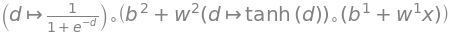

In [39]:
net_sp(params_sp, x_sp)

In [40]:
# Flatten all the JAX parameters for substitution into the SymPy explicit 
all_params_jax = np.concatenate([a.reshape(-1) for a in params_jax]).tolist()

In [41]:
all_params_jax

In [42]:
x_subs = {k: v for k, v in zip(x_sp[:],x_jax.reshape(-1).tolist())}
param_subs = {k: v for k, v in zip(all_params, all_params_jax)}

In [43]:
net_sp(params_sp, x_sp).as_explicit().subs(param_subs).subs(x_subs)

[0.491141733424738]

In [44]:
cross_entropy_jax = create_cross_entropy(lambda x: np.log(x), lambda x: 1-x)

In [45]:
loss_jax = create_loss(cross_entropy_jax, net_jax)

In [46]:
loss_jax(params_jax, x_jax, 1)

Array([[0.71102244]], dtype=float32)

In [47]:
loss_sp(params_sp, x_sp, y_sp).as_explicit().subs(param_subs).subs(x_subs).subs({y_sp[0,0]: 1})

[0.711022530063193]

In [48]:
jax.jacobian(loss_jax)(params_jax, x_jax, 1)

[Array([[[[ 0.48920286,  0.20289083],
          [-0.2218594 , -0.09201343],
          [-0.00623505, -0.00258591]]]], dtype=float32),
 Array([[[[ 0.4339824 ],
          [-0.19681625],
          [-0.00553125]]]], dtype=float32),
 Array([[[[ 0.00756729, -0.38085452,  0.50529   ]]]], dtype=float32),
 Array([[[[-0.5088582]]]], dtype=float32)]

In [49]:
loss_grad_sp.subs(param_subs).subs(x_subs).subs({y_sp[0,0]: 1})

[0.489202901533394  0.20289085007709  -0.22185944760121  -0.0920134606322863  -0.00623499326163677  -0.00258588630425786  0.433982450703  -0.196816303582399  -0.0055311970
7041865  0.007567294987252  -0.380854546170986  0.505290051152341  -0.508858266575262]

# Loss with Tensor Terms
It would be nice to keep the parameters in their original tensor form while substituting and taking derivative, rather than flattening all the parameters.  

In [50]:
loss_sp(params_sp, x_sp, sp.Matrix([1]))

     ⎛       ⎛   1   ⎞⎞                                                        ⎛ ⎛       1   ⎞                                          ⎞
[-1]⋅⎜d ↦ log⎜───────⎟⎟˳(w²⋅(d ↦ tanh(d))˳(w¹⋅x + b¹) + b²) + [0]⋅(d ↦ log(d))˳⎜-⎜d ↦ ───────⎟˳(w²⋅(d ↦ tanh(d))˳(w¹⋅x + b¹) + b²) + [1]⎟
     ⎜       ⎜     -d⎟⎟                                                        ⎜ ⎜         -d⎟                                          ⎟
     ⎝       ⎝1 + ℯ  ⎠⎠                                                        ⎝ ⎝    1 + ℯ  ⎠                                          ⎠

In [51]:
subs_matrix = (
    {s: sp.Matrix(j) for s, j in dict(zip(params_sp, params_jax)).items()} 
    | {x_sp: sp.Matrix(x_jax)} 
    | {y_sp: sp.Matrix([1])}
)
subs_matrix

⎧    ⎡ 0.127840403167285 ⎤                               ⎡0.304717079754431  -1.0399841062405 ⎤                                                                            
⎪    ⎢                   ⎥                               ⎢                                    ⎥                                                                    ⎡1.12724
⎨b¹: ⎢-0.316242592343582 ⎥, b²: [0.066030697561216], w¹: ⎢0.750451195806457  0.940564716391214⎥, w²: [-0.85304392757358  0.879397974862829  0.777791935428948], x: ⎢       
⎪    ⎢                   ⎥                               ⎢                                    ⎥                                                                    ⎣0.46750
⎩    ⎣-0.0168011575042888⎦                               ⎣-1.95103518865384  -1.30217950686232⎦                                                                            

                   ⎫
120696803 ⎤        ⎪
          ⎥, y: [1]⎬
9342252046⎦        ⎪
                   ⎭

In [52]:
subs_matrix_explicit = (
    {s.as_explicit(): sp.Matrix(j) for s, j in dict(zip(params_sp, params_jax)).items()} 
    | {x_sp.as_explicit(): sp.Matrix(x_jax)} 
    | {y_sp.as_explicit(): sp.Matrix([1])}
)
subs_matrix_explicit

⎧                                                                                                                                                    ⎡b¹₀₀⎤  ⎡ 0.1278404031
⎪                                                                                                                        ⎡x₀₀⎤  ⎡1.12724120696803 ⎤  ⎢    ⎥  ⎢             
⎨[b²₀₀]: [0.066030697561216], [y₀₀]: [1], [w²₀₀  w²₀₁  w²₀₂]: [-0.85304392757358  0.879397974862829  0.777791935428948], ⎢   ⎥: ⎢                 ⎥, ⎢b¹₁₀⎥: ⎢-0.3162425923
⎪                                                                                                                        ⎣x₁₀⎦  ⎣0.467509342252046⎦  ⎢    ⎥  ⎢             
⎩                                                                                                                                                    ⎣b¹₂₀⎦  ⎣-0.0168011575

67285 ⎤  ⎡w¹₀₀  w¹₀₁⎤  ⎡0.304717079754431  -1.0399841062405 ⎤⎫
      ⎥  ⎢          ⎥  ⎢                                    ⎥⎪
43582 ⎥, ⎢w¹₁

In [53]:
subs_params_explicit = dict(
    zip(
        [i for k in subs_matrix_explicit.keys() for i in k.flat()],
        [i for v in subs_matrix_explicit.values() for i in v.flat()]
    )
)
subs_params_explicit

In [54]:
net_sp(params_sp, x_sp).subs(subs_matrix)

              ⎛                                                                        ⎛⎡0.304717079754431  -1.0399841062405 ⎤                       ⎡ 0.127840403167285 ⎤⎞
⎛       1   ⎞ ⎜                                                                        ⎜⎢                                    ⎥ ⎡1.12724120696803 ⎤   ⎢                   ⎥⎟
⎜d ↦ ───────⎟˳⎜[-0.85304392757358  0.879397974862829  0.777791935428948]⋅(d ↦ tanh(d))˳⎜⎢0.750451195806457  0.940564716391214⎥⋅⎢                 ⎥ + ⎢-0.316242592343582 ⎥⎟
⎜         -d⎟ ⎜                                                                        ⎜⎢                                    ⎥ ⎣0.467509342252046⎦   ⎢                   ⎥⎟
⎝    1 + ℯ  ⎠ ⎝                                                                        ⎝⎣-1.95103518865384  -1.30217950686232⎦                       ⎣-0.0168011575042888⎦⎠

                      ⎞
                      ⎟
 + [0.066030697561216]⎟
                      ⎟
                      ⎠

In [55]:
net_sp(params_sp, x_sp).subs(subs_matrix).doit()

[0.491141730315985]

In [56]:
loss_sp(params_sp, x_sp, y_sp).as_explicit().subs(subs_params_explicit)

[0.711022536392839]

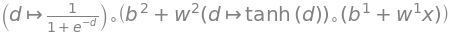

In [57]:
net_sp(params_sp, x_sp)

In [77]:
(w2 @ (w1 @ x_sp + b1).applyfunc(sp.tanh) + b2).applyfunc(lambda x: (1+sp.tanh(x/2))/2).simplify() # .subs(subs_matrix).doit()

In [59]:
loss_sp(params_sp, x_sp, y_sp).subs(subs_matrix)

TypeError: Mix of Matrix and Scalar symbols

In [ ]:
net_sp(params_sp, x_sp).diff(b1)

In [76]:
x = sp.symbols('x', real=True)
(1/(1+sp.exp(-x))).rewrite(sp.tanh).simplify()